## Code to train DQN with APSF representations

In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
!mkdir log

mkdir: log: File exists


In [2]:
import sys,os
sys.path.append('')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
layout = '4rooms'

if layout == '3rooms' or layout == '3roomsh':
  cell_num = 101
  max_step_dqn = 1e5
  linear_schedule_dqn = 6e4
elif layout == 'maze':
  cell_num = 75
  max_step_dqn = 1.5e5
  linear_schedule_dqn = 9e4
else:
  cell_num = 104
  max_step_dqn = 7e4
  linear_schedule_dqn = 4e4

import pickle

def store_agent(obj, agent_name):
  print('storing network')
  pickle.dump(obj, open('./agent/'+agent_name + '.p', 'wb'))

def load_agent(agent_name, layout=layout):
  filename = agent_name + '.p'
  return pickle.load(open('/content/gdrive/My Drive/DeepRL/agent/'+filename, 'rb'))

In [6]:
learning_rate_dqn = 2e-3 #from 0.05 - 0.001

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.DEVICE = torch.device('cpu')
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dqn)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dqn)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dqn
    config.async_actor = False
    agent = DQNAgent(config)

    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.step()
    # plt.figure(figsize=(10,4))
    while True:
        # print(agent.actor._task.env.envs[0].goal)
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        # plt.title('step: {}'.format(agent.total_steps), fontsize=20)
        # plt.imshow(agent.actor._task.env.envs[0].render(), cmap='Blues', )
        agent.switch_task()
    return agent

In [ ]:
def dqn_test(agent):
  step = 0
  while True:
        if not step % 1000:
          agent.eval_episodes()
        step += 1

### Prepare 10 policies

In [10]:
goal1 = str(random.randint(0, cell_num))
goal2 = str(random.randint(0, cell_num))
goal3 = str(random.randint(0, cell_num))
goal4 = str(random.randint(0, cell_num))
goal5 = str(random.randint(0, cell_num))

goal1 = str(44)
goal2 = str(82)
goal3 = str(80)

p1 = dqn_feature(game='FourRoomsMatrix-Goal-'+goal1)
p2 = dqn_feature(game='FourRoomsMatrix-Goal-'+goal2)
p3 = dqn_feature(game='FourRoomsMatrix-Goal-'+goal3)
# p4 = dqn_feature(game='FourRoomsMatrix-Goal-'+goal4)
# p5 = dqn_feature(game='FourRoomsMatrix-Goal-'+goal5)

2021-03-22 00:38:10,162 - root - INFO: steps 0, episodic_return_test -180.10(18.88)


KeyboardInterrupt: 

In [ ]:
load_agent('DQN-3rooms-goal=44')

VanillaNet(
  (fc_head): Linear(in_features=16, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=169, out_features=16, bias=True)
    )
  )
)

(Text(0.5, 0, 'timesteps'), Text(0, 0.5, 'returns'))

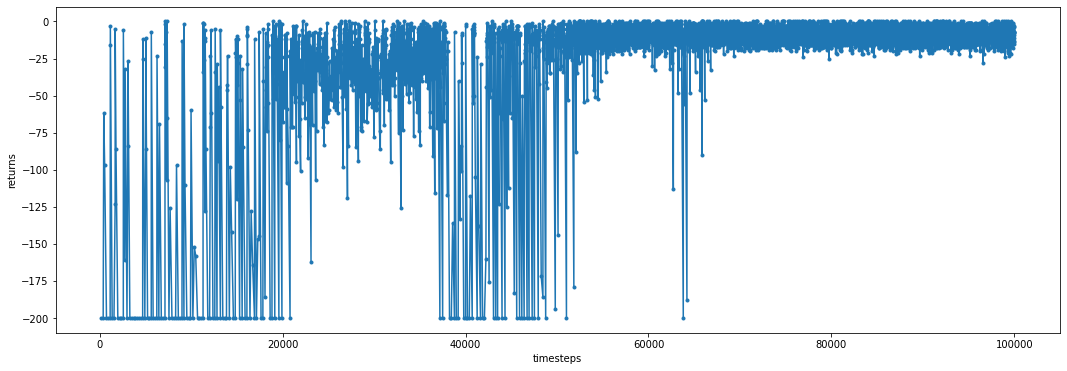

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(np.array(p1.returns)[:,0], np.array(p1.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
# plt.title('DQN performance on ' + game), plt.show()

### Learning the state representations using APSF

In [ ]:
max_step_avdsr = 3e5
linear_schedule_avdsr = 3e5
learning_rate_avdsr = 1e-3 #from 0.05 - 0.001

def avdsr_feature_A(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_avdsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, linear_schedule_avdsr) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = max_step_avdsr
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.network = load_agent('avdsr-A')
    try:
      agent.network = load_agent('avdsr-A-'+game)
    except:  
      while True:
          if config.log_interval and not agent.total_steps % config.log_interval:
              agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
              t0 = time.time()
          if config.max_steps and agent.total_steps >= config.max_steps:
              store_agent(agent.network, 'avdsr-A-'+game)
              return agent
              break
  #         import pdb; pdb.set_trace()
          agent.step()
          agent.switch_task()
      

### Train A Base Successor Feature via Phase-A Traning

In [ ]:
avdsr = avdsr_feature_A(game='FourRoomsMatrixNoTerm', agents=[p1], choice=0)

2021-03-16 11:51:40,301 - root - INFO: steps 0, 127100121.21 steps/s
2021-03-16 11:51:41,292 - root - INFO: steps 1000, 1016.06 steps/s
2021-03-16 11:51:42,263 - root - INFO: steps 2000, 1041.46 steps/s
2021-03-16 11:51:43,192 - root - INFO: steps 3000, 1084.73 steps/s
2021-03-16 11:51:44,080 - root - INFO: steps 4000, 1131.44 steps/s
2021-03-16 11:51:44,958 - root - INFO: steps 5000, 1148.63 steps/s
2021-03-16 11:51:45,835 - root - INFO: steps 6000, 1147.39 steps/s
2021-03-16 11:51:46,723 - root - INFO: steps 7000, 1132.08 steps/s
2021-03-16 11:51:47,623 - root - INFO: steps 8000, 1117.76 steps/s
2021-03-16 11:51:48,497 - root - INFO: steps 9000, 1151.95 steps/s
2021-03-16 11:51:49,359 - root - INFO: steps 10000, 1170.54 steps/s
2021-03-16 11:51:50,250 - root - INFO: steps 11000, 1130.64 steps/s
2021-03-16 11:51:51,138 - root - INFO: steps 12000, 1133.04 steps/s
2021-03-16 11:51:52,020 - root - INFO: steps 13000, 1141.17 steps/s
2021-03-16 11:51:52,908 - root - INFO: steps 14000, 1133

NameError: ignored

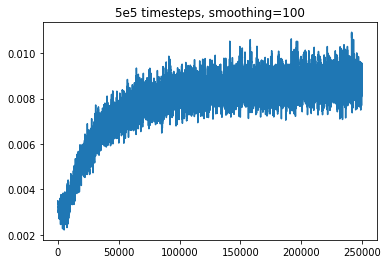

(Text(0.5, 1.0, '5e5 timesteps, smoothing=100'), None)

In [ ]:
# loss_lr_em3 = SR_set[0].loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec, kernel))
plt.title('5e5 timesteps, smoothing=' + str(kernel)), plt.show()
# plt.subplot(122), plt.plot(avdsr.retu)

### Train Multiple Fine-Tuned Successor Features via Phase-B Training (Based on the SR we already get from Phase-A)

In [ ]:
network_fn = lambda: SRNet(avdsr.network.output_dim, SRIdentityBody(169), \
                                      hidden_units=(), config=0) #CHECK
                      
net = network_fn()

net.load_state_dict(avdsr.network.state_dict())

<All keys matched successfully>

In [ ]:
SR_set = []
num_SR = 5

max_step_avdsr = 3e5
linear_schedule_avdsr = 3e4
learning_rate_avdsr = 2e-3 #from 0.05 - 0.001

def avdsr_feature_B(ref=avdsr, **kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_avdsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.5, 0.5, linear_schedule_avdsr) # CHECK what proportion of time we want the agent to explore or follow the trained policy
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = max_step_avdsr
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    if ref :
      agent.network.load_state_dict(ref.network.state_dict())
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()

# p = avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[p1], choice=0)

SR_set.append(avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[p1], choice=0))
SR_set.append(avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[p2], choice=0))
SR_set.append(avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[p3], choice=0))
# SR_set.append(avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[p4], choice=0))
# SR_set.append(avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[p5], choice=0))
p = SR_set[0]

# for i in range(num_SR):
#   print('Starting generate successor feature : ', (i + 1))
#   fine_tuned_SR = avdsr_feature_B(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)
#   SR_set.append(fine_tuned_SR)
#   print('Successor feature ', (i + 1), 'successfully generated')

2021-03-16 11:30:39,566 - root - INFO: steps 0, 209715200.00 steps/s
2021-03-16 11:30:40,551 - root - INFO: steps 1000, 1021.27 steps/s
2021-03-16 11:30:41,529 - root - INFO: steps 2000, 1029.57 steps/s
2021-03-16 11:30:42,491 - root - INFO: steps 3000, 1043.21 steps/s
2021-03-16 11:30:43,454 - root - INFO: steps 4000, 1045.18 steps/s
2021-03-16 11:30:44,422 - root - INFO: steps 5000, 1035.97 steps/s
2021-03-16 11:30:45,386 - root - INFO: steps 6000, 1044.33 steps/s
2021-03-16 11:30:46,341 - root - INFO: steps 7000, 1054.60 steps/s
2021-03-16 11:30:47,304 - root - INFO: steps 8000, 1042.61 steps/s
2021-03-16 11:30:48,235 - root - INFO: steps 9000, 1082.90 steps/s
2021-03-16 11:30:49,178 - root - INFO: steps 10000, 1065.22 steps/s
2021-03-16 11:30:50,116 - root - INFO: steps 11000, 1073.85 steps/s
2021-03-16 11:30:51,059 - root - INFO: steps 12000, 1066.85 steps/s
2021-03-16 11:30:51,992 - root - INFO: steps 13000, 1079.15 steps/s
2021-03-16 11:30:52,909 - root - INFO: steps 14000, 1099

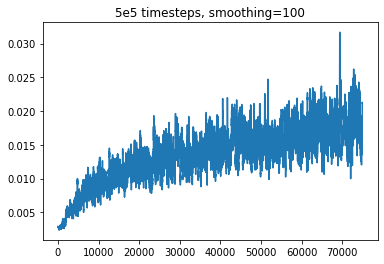

(Text(0.5, 1.0, '5e5 timesteps, smoothing=100'), None)

In [ ]:
# loss_lr_em3 = SR_set[0].loss_vec
kernel = 100
plt.plot(convolve(SR_set[0].loss_vec, kernel))
plt.title('5e5 timesteps, smoothing=' + str(kernel)), plt.show()
# plt.subplot(122), plt.plot(avdsr.retu)

33 33 33


Text(0.5, 1.0, 'Principle components of SFs using PCA')

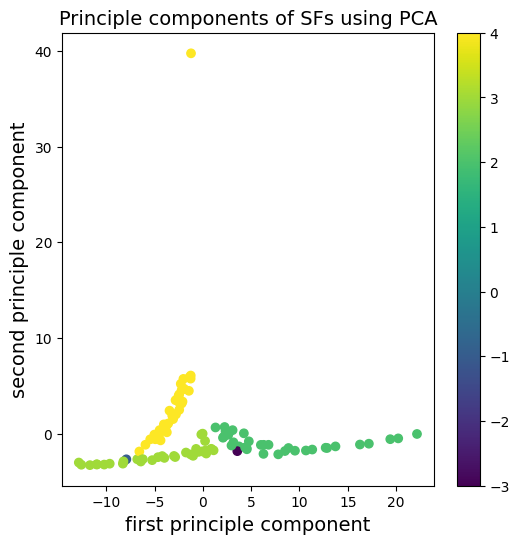

In [ ]:
from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]

room1, room2, room3 = [], [], []
num = 0

agent_to_check = SR_set[0]

if layout == '4rooms':
    num = 104
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -3, -5, -7]
elif layout == '3roomsh':
    num = 101
    c = np.ones(101)*4
    room1 = list(range(0,22))
    room2 = list(range(23,67)) 
    room3 = list(range(68,101))
    connect = [22, 67]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -3]
elif layout == 'maze':
    num = 75
    c = np.ones(75)*4
    room1 = list(range(12)) + [13, 22, 26, 33, 14, 23, 27, 34, 41, 48, 52, 61, 47, 51, 60, 63] + list(range(64, 75))
    room2 = list(range(15, 22)) + [24, 28, 35, 42, 49, 25, 32, 40, 46, 50] + list(range(53, 60))
    room3 = [29, 30, 31, 37, 38, 43, 44, 45]
    connect = [12, 62, 36, 39]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -3, -5, -7]
elif layout == '3rooms':
    num = 101
    c = np.ones(101)*4
    room1 = [0,1,2,9,10,11,83,84,85,92,93,94] + list(range(19, 74, 9)) + list(range(20, 75, 9)) + list(range(21, 76, 9))
    room2 = [3,4,5,12,13,14,77,78,79,86,87,88,95,96,97] + list(range(22, 68, 9)) + list(range(23, 69, 9)) + list(range(24, 70, 9))
    room3 = [6,7,8,80,81,82,89,90,91,98,99,100] + list(range(16, 71, 9)) + list(range(17,72, 9)) + list(range(18, 73, 9))
    connect = [15, 76]
    c[room1] = 2
    c[room2] = 3
    c[room3] = 4
    c[connect] = [-1, -3]
elif layout == '3roomsm':
    num = 101
    c = np.ones(101) * 4
    room1 = [0, 1, 9, 10] + list(range(19, 74, 9)) + list(range(20, 75, 9)) + [83, 84, 92, 93]
    room2 = list(range(2, 6)) + list(range(11, 15)) + list(range(21, 67, 9)) + list(range(22, 68, 9)) + list(range(23, 69, 9)) + list(range(24, 70, 9)) + list(range(76, 80)) + list(range(85, 89)) + list(range(94, 98))
    room3 = [6,7,8] + list(range(16, 71, 9)) + list(range(17, 72, 9)) + list(range(18, 73, 9)) + [80, 81, 82, 89, 90, 91, 98, 99, 100]
    connect = [15, 75]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1]

print(len(room1), len(room2), len(room3))

env = FourRoomsMatrix()
psi_all = np.zeros((num,169*4))
for i in range(num):
    state = env.reset(init=i)
    _, out, _ = agent_to_check.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=100)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)
plt.colorbar()
plt.title('Principle components of SFs using PCA', fontsize=14)

### Test the performance of GPI agent


### Fast RL Experiments

In [ ]:
style = 0 # linear MPSF

if style == 1:
  learning_rate_dsr = 1e-3 #from 0.05 - 0.001
else:
  learning_rate_dsr = 5e-3

linear_schedule_dsr = 6e4
clip = 50000
smooth = clip // 10

max_step_dsr = 1e5

def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn


def plot_rewards(rewards, plot_seperate=True , clip=clip, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()


def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dsr)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dsr
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

# r_c1 = runNAgents(dsr_feature_init, runs=3 , freeze=2, ref=p, style=1)

# rewards_dict = {'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c1[1:]}

# plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on' + layout + 'env' + str(learning_rate_dsr))

target = dsr_feature_init(game='FourRoomsMatrix-Goal-62', freeze=2, ref=SR_set[0], style=style)

2021-03-16 12:05:42,240 - root - INFO: steps 0, episodic_return_test -12.70(2.91)


<All keys matched successfully>


2021-03-16 12:05:47,280 - root - INFO: steps 5000, episodic_return_test -160.40(25.05)
2021-03-16 12:05:52,413 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2021-03-16 12:05:57,525 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
Process AsyncReplay-53:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/content/gdrive/My Drive/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
from deep_rl.agent.GPI_agent import *
# import fourrooms

def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0, agents=None, target=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style, agents=agents, target=target)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn


def plot_rewards(rewards, plot_seperate=True , clip=clip, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()


def gpi_feature(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, linear_schedule_dsr)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dsr
    config.async_actor = False
    
    agent = GPIAgent(config, agents=SR_set, target=target,)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval: 
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        # agent.eval_episodes()
        # time.sleep(0.2)
        agent.step()
        # agent.actor._task.env.render()
        # time.sleep(0.2)
        agent.switch_task()
    # agent.step()
    return agent


GPI = gpi_feature(game='FourRoomsMatrix-Goal-62', freeze=2, ref=None, style=style)
# gpi = runNAgents(gpi_feature, runs=3 , freeze=2, ref=None, style=0)


# rewards_dict = {'GPI($\pi_{\epsilon=1}$)': r_c1[1:]}


# plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on' + layout + 'env' + str(learning_rate_dsr))

2021-03-16 11:46:15,668 - root - INFO: steps 0, episodic_return_test -180.10(18.88)
2021-03-16 11:46:19,733 - root - INFO: steps 5000, episodic_return_test -160.40(25.05)
2021-03-16 11:46:23,918 - root - INFO: steps 10000, episodic_return_test -180.10(18.88)
2021-03-16 11:46:27,818 - root - INFO: steps 15000, episodic_return_test -140.20(28.89)
Process AsyncReplay-42:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/content/gdrive/My Drive/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

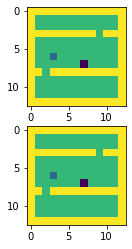

In [10]:
env = FourRooms()
env.reset()
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(env.render())
plt.subplot(2, 1, 2)
plt.imshow(env.render())

In [1]:
import gym
import time
env = gym.make('CartPole-v0')   #创造环境
observation = env.reset()       #初始化环境，observation为环境状态
count = 0
for t in range(100):
    action = env.action_space.sample()  #随机采样动作
    observation, reward, done, info = env.step(action)  #与环境交互，获得下一步的时刻
    if done:             
        break
    env.render()         #绘制场景
    count+=1
    time.sleep(0.2)      #每次等待0.2s
print(count)             #打印该次尝试的步数

/Users/yiranwang/Downloads/LiNCLAB/State representation in RL/venv-MPSF/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


16


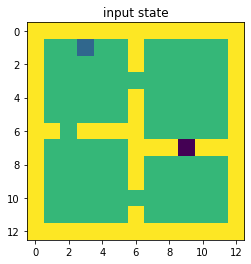

NameError: name 'target' is not defined

In [4]:
from deep_rl.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix()
state = env.reset(init=24)
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
# env.current_cell = (5,5)
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); 
plt.title('input state'), 
plt.show()
phi, out, q = target.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.figure(dpi = 100)
plt.imshow(phi.reshape((13, 13)))

plt.show()

print(q)
print(env.current_cell)

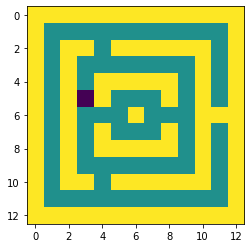

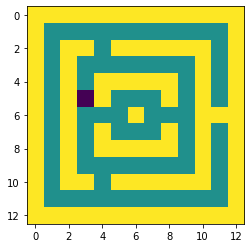

In [ ]:
env = FourRoomsMatrix(layout='maze')
state = env.reset(init=g[1])
plt.imshow(env.render(show_goal=False))

In [ ]:
params_count(avdsr.network.psi2q)

169

169

# Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [ ]:
def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [ ]:
max_step_dsr = 5e4
linear_schedule_dsr = 3e4
runs = 2
clip = 200000
smooth = clip // 20

# Function for Systematic Grid Search

 # Best Hyper-Parameters :
 
 ## 4rooms : max_step = 5e4
 ### For DQN : learning rate = 6e-3, Decay = 3e4 -> (-6.22, 29900)

 ### For MPSF169 : learning rate = 1e-3, Decay = 3e4

 ### For MPSF2708 : (6e-3, 3.5e4) -> (-5.56, 45300), (5e-3, 3e4) -> (-7.01, 24000)

 ## Maze : max_step = 1e5
 ### For DQN : learning rate = 9e-3, Decay = 7e4-> (Performance = -8.93 / Convergence = 55400.0 / Epi = 29.0 / Total Epi = 5993)

 ### For MPSF169 : learning rate = 0.9e-4, Decay = 5e4 -> (-9.45, 38000, mean_performance = -13.60)

 ### For MPSF2708 : learning rate = 8e-3, Decay = 8e4 -> (Performance = -8.81 / Convergence = 60300.0 / Epi = 16.0 / Total Epi = 5863)

  ## 3rooms : max_step = 1e5
  ### For DQN : learning_rate = 3e-3, Decay = 8e4 -> (Performance = -14.02 / Convergence = 64800.0 / Epi = 10.0 / Total Epi = 3727 /Mean_Performance = -25.86 )
  ### For MPSF169 : learning_rate = 9e-4, Decay = 9e4 -> (Performance = -14.01 / Convergence = 72800.0 / Epi = 6.0 / Total Epi = 3452 / Mean_Performance = -27.99 )

### For MPSF2708 : learning_rate = 1e-3, Decay = 6e4 -> (Performance = -13.76 / Convergence = 48400.0 / Epi = 3.0 / Total Epi = 4459)

## 3roomsh : max_step = 5e4
### For DQN : learning_rate = 4e-3, Decay = 4e4 -> (Performance = -8.45 / Convergence = 35800.0 / Epi = 25.0 / Total Epi = 2491)

### For MPSF169 : learning rate = 9e-4, Decay = 3e4 -> (Performance = -8.75 / Convergence = 34000.0 / Epi = 21.0 / Total Epi = 3035)

### For MPSF2708 :learning_rate = 8e-3, Decay = 4e4 -> (Performance = -8.26 / Convergence = 29700.0 / Epi = 18.0 / Total Epi = 2970)

In [ ]:
import pickle

def convertE(float):
  return '%.1e' % float

def store(obj, filename):
  pickle.dump(obj, open('/content/gdrive/My Drive/DeepRL/performance_dicts/'+filename, 'wb'))

def load(model, rate, decay, layout=layout):
  filename = model + '--' + layout + '--rate=' + convertE(rate) + '--decay=' + convertE(decay) + '.p'
  return pickle.load(open('/content/gdrive/My Drive/DeepRL/performance_dicts/'+filename, 'rb'))

# Analysis Function

In [ ]:
def analysis(results, rate, decay, tolorance_factor = 1.5, model = 'MPSF169'):
  t_reward = results[1]
  r_reward = results[2]
  rewards = {'convolved rewards vector': results[1:]}

  # getting the mean results of multiple runs
  mean = float('-inf')
  for j, (k, v) in enumerate(rewards.items()):
    r_vec = np.zeros((len(v[0]), clip-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
      r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=0)
    
  # analyze the result to pick the best one
  # Final Performance (we consider the mean of last 1/3 reward as finally / converged performance)
  performance = np.mean(np.array(r_reward[0])[len(r_reward[0]) * 2 // 3:])

  # Mean of the performance of all time
  mean_performance = np.mean(np.array(r_reward[0]))

  # find how fast does the agent converge
  # For now, the criteria of convergence is that, if the agents reach the 1.5 times
  # of best performance so far, we consider it starting to converge
  starting_converge_pivot = performance * tolorance_factor
  # print(starting_converge_pivot)
  convergence_point = float('inf')
  for step in range(0, len(mean), 100):
    # print(mean[step])
    if np.mean(mean[step - 99:step + 1]) >= starting_converge_pivot:
      convergence_point = step
      break

  convergence_episode = float('inf')
  for epi in range(len(r_reward[0])):
    if r_reward[0][epi] >= starting_converge_pivot:
      convergence_episode = epi
      break

  dic = {
      'mean' : mean,
      'performance' : performance,
      'mean_performance' : mean_performance,
      'convergence_point' : convergence_point,
      'convergence_episode' : convergence_episode,
      'total_episode' : len(r_reward[0]),
      'mean' : mean
  }

  # pickle file name format : agents_name--layout--rate=[rate]--decay=[decay].p
  store(dic, model + '--' + layout + '--rate=' + convertE(rate) + '--decay=' + convertE(decay) + '.p')

  return dic

In [ ]:
file_MPSF169 = open("/content/gdrive/My Drive/DeepRL/Performance_Data/3rooms/MPSF2708", "w")

In [ ]:
model = 'MPSF169'

from numpy import arange

function_name = "dqn"

clip = 100000
smooth = clip // 10

max_steps_dqn = 5e4
max_steps_dsr = 5e4

def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

def find_best_parameters(function = 1, \
                         learning_rate_range = [5e-2, 8e-4], learning_rate_changing = 5e-3, \
                         decay_rate_range = [3e4, 5e4], decay_changing = 1e4, \
                         hard = True, \
                         tolorance_factor = 1.5, \
                         runs = 2):
  
  best_performance = float('-inf')
  best_convergence = float('inf')
  best_learning_rate = 0
  best_decay_rate = 0

  model = ''
  if function == 1:
    model = 'DQN'
  elif function == 2:
    model = 'MPSF169'
  else:
    model = 'MPSF2708'

  for decay in arange(decay_rate_range[0], decay_rate_range[1], decay_changing):
    rate = learning_rate_range[0]
    # for rate in arange(learning_rate_range[0], learning_rate_range[1], learning_rate_changing):
    while rate >= learning_rate_range[1]:
      file_MPSF169 = open("/content/gdrive/My Drive/DeepRL/Performance_Data/" + layout + '/' + model, "a")
      if function == 2 or function == 3:
        def training_function(ref,**kwargs):
          generate_tag(kwargs)
          kwargs.setdefault('log_level', 0)
          config = Config()
          config.merge(kwargs)

          config.task_fn = lambda: Task(config.game)
          config.eval_env = config.task_fn()
          config.c = 1

          config.optimizer_fn = lambda params: torch.optim.RMSprop(params, rate)
          config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
          config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

          config.random_action_prob = LinearSchedule(1.0, 0.1, decay)
          config.discount = 0.99
          config.target_network_update_freq = 200
          config.exploration_steps = 0
          # config.double_q = True
          config.double_q = False
          config.sgd_update_frequency = 4
          config.gradient_clip = 5
          config.eval_interval = int(5e3)
          config.max_steps = max_steps_dsr
          config.async_actor = False
          
          agent = DSRAgent(config)
          #run_steps function below
          config = agent.config
          agent_name = agent.__class__.__name__
          if(ref is not None):
              print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
          t0 = time.time()
          while True:
              if config.save_interval and not agent.total_steps % config.save_interval:
                  agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
              if config.log_interval and not agent.total_steps % config.log_interval:
      #             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
                  t0 = time.time()
              if config.eval_interval and not agent.total_steps % config.eval_interval:
                  # agent.eval_episodes()
                  pass
              if config.max_steps and agent.total_steps >= config.max_steps:
                  return agent
                  break
      #         import pdb; pdb.set_trace()
              agent.step()
              agent.switch_task()
          return agent

      else:
        def training_function(**kwargs):
          generate_tag(kwargs)
          kwargs.setdefault('log_level', 0)
          config = Config()
          config.merge(kwargs)

          config.task_fn = lambda: Task(config.game)
          config.eval_env = config.task_fn()

          config.optimizer_fn = lambda params: torch.optim.RMSprop(params, rate)
          config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
          config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

          config.random_action_prob = LinearSchedule(1.0, 0.1, decay)
          config.discount = 0.99
          config.target_network_update_freq = 200
          config.exploration_steps = 0
          # config.double_q = True
          config.double_q = False
          config.sgd_update_frequency = 4
          config.gradient_clip = 5
          config.eval_interval = int(5e3)
          config.max_steps = max_steps_dqn
          config.async_actor = False
          agent = DQNAgent(config)
          #run_steps function below
          config = agent.config
          agent_name = agent.__class__.__name__
          t0 = time.time()
          while True:
            if config.save_interval and not agent.total_steps % config.save_interval:
              agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
              pass
            if config.log_interval and not agent.total_steps % config.log_interval:
              t0 = time.time()
            if config.eval_interval and not agent.total_steps % config.eval_interval:
              # agent.eval_episodes()
              pass
            if config.max_steps and agent.total_steps >= config.max_steps:
              return agent
              break
            agent.step()
            agent.switch_task()
          return agent

          

      # training the model 
      if function == 2:
        results = runNAgents(training_function, runs=runs, freeze=2, ref=avdsr, style=1)
      elif function == 3:
        results = runNAgents(training_function, runs=runs, freeze=2, ref=avdsr, style=0)
      else:
        results = runNAgents(training_function, runs=runs)

      dic = analysis(results, rate, decay, tolorance_factor, model)
      performance = dic['performance']
      mean_performance = dic['mean_performance']
      convergence_point = dic['convergence_point']
      convergence_episode = dic['convergence_episode']
      total_episode = dic['total_episode']
      # t_reward = results[1]
      # r_reward = results[2]
      # rewards = {'convolved rewards vector': results[1:]}

			# # getting the mean results of multiple runs
      # mean = float('-inf')
      # for j, (k, v) in enumerate(rewards.items()):
      #   r_vec = np.zeros((len(v[0]), clip-smooth+1))
      #   for i, (t, r) in enumerate(zip(v[0], v[1])):
      #     r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

      #   mean = np.mean(np.array(r_vec), axis=0)
		  	
      # # analyze the result to pick the best one
      # # Final Performance (we consider the mean of last 1/3 reward as finally / converged performance)
      # performance = np.mean(np.array(r_reward[0])[len(r_reward[0]) * 2 // 3:])

      # # Mean of the performance of all time
      # mean_performance = np.mean(np.array(r_reward[0]))

      # # find how fast does the agent converge
      # # For now, the criteria of convergence is that, if the agents reach the 1.5 times
      # # of best performance so far, we consider it starting to converge
      # starting_converge_pivot = performance * tolorance_factor
      # # print(starting_converge_pivot)
      # convergence_point = float('inf')
      # for step in range(0, len(mean), 100):
      #   # print(mean[step])
      #   if np.mean(mean[step - 99:step + 1]) >= starting_converge_pivot:
      #     convergence_point = step
      #     break

      # convergence_episode = float('inf')
      # for epi in range(len(r_reward[0])):
      #   if r_reward[0][epi] >= starting_converge_pivot:
      #     convergence_episode = epi
      #     break

      # writer.writerow([rate, decay, performance, convergence_point, best_performance, best_convergence])
      # print('Learning rate = %.2f | Decay = %.2f | (Performance = %.2f / Convergence = %d) | (Best Performance = %.2f / Convergence = %d)' % (rate, decay, performance, convergence_point, best_performance, best_convergence))

      # if hard = True, it means we have to find the absolute best performance (no tolorance)
      if hard:
        if best_performance < performance:
          best_convergence = convergence_point
          best_performance = performance
          best_learning_rate = rate
          best_decay_rate = decay
        elif best_performance == performance:
          best_convergence = min(convergence_point, best_convergence)
          if best_convergence == convergence_point:
            best_learning_rate = rate
            best_decay_rate = decay 
      # if hard = False, it means we have to find the generally best performance (with some tolorance)
      else:
        # if two performance has gap lower than 1, we consider they are both good
        if abs(performance - best_performance) < 1:
          best_convergence = min(best_convergence, convergence_point)
          if best_convergence == convergence_point:
            best_learning_rate = rate
            best_decay_rate = decay
        elif performance > best_perfoamcne:
            best_performance = performance
            best_convergence = convergence_point
            best_learning_rate = rate
            best_decay_rate = decay

      print('Learning rate = %.4f | Decay = %.2f | (Performance = %.2f / Convergence = %.1f / Epi = %.1f / Total Epi = %d) / (Best performance = %.2f / Convergence = %.1f) | Mean_Performance = %.2f \n' % (rate, decay, performance, convergence_point, convergence_episode, total_episode, best_performance, best_convergence, mean_performance))
      file_MPSF169.writelines('Learning rate = %.4f | Decay = %.2f | (Performance = %.2f / Convergence = %.1f / Epi = %.1f / Total Epi = %d) / (Best performance = %.2f / Convergence = %.1f) | Mean_Performance = %.2f \n' % (rate, decay, performance, convergence_point, convergence_episode, total_episode, best_performance, best_convergence, mean_performance))
      file_MPSF169.close()
      change = 1e3
      if rate > 1e-2:
        change = 1e-2
      elif rate > 1e-3:
        change = 1e-3
      else: change = 1e-4
      
      rate = rate - change


  return best_learning_rate, best_decay_rate

In [ ]:
best_parameters = find_best_parameters(function = 3, runs=1)

<All keys matched successfully>
Learning rate = 0.0500 | Decay = 30000.00 | (Performance = -188.35 / Convergence = 100.0 / Epi = 0.0 / Total Epi = 319) / (Best performance = -188.35 / Convergence = 100.0) | Mean_Performance = -155.92 



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<All keys matched successfully>
Learning rate = 0.0400 | Decay = 30000.00 | (Performance = -190.66 / Convergence = 100.0 / Epi = 0.0 / Total Epi = 294) / (Best performance = -188.35 / Convergence = 100.0) | Mean_Performance = -169.35 

<All keys matched successfully>
Learning rate = 0.0300 | Decay = 30000.00 | (Performance = -22.63 / Convergence = 20400.0 / Epi = 17.0 / Total Epi = 1776) / (Best performance = -22.63 / Convergence = 20400.0) | Mean_Performance = -27.19 

<All keys matched successfully>
Learning rate = 0.0200 | Decay = 30000.00 | (Performance = -9.15 / Convergence = 29500.0 / Epi = 15.0 / Total Epi = 3077) / (Best performance = -9.15 / Convergence = 29500.0) | Mean_Performance = -15.26 

<All keys matched successfully>
Learning rate = 0.0100 | Decay = 30000.00 | (Performance = -8.61 / Convergence = 26600.0 / Epi = 38.0 / Total Epi = 3263) / (Best performance = -8.61 / Convergence = 26600.0) | Mean_Performance = -14.33 

<All keys matched successfully>
Learning rate = 0.0

In [ ]:
file_MPSF169.close()

In [ ]:
avdsr = avdsr_feature_A(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)

abd 
 sss


### Performance of DQN agent

runs:   0%|          | 0/2 [00:00<?, ?it/s]2021-03-08 14:56:49,465 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2021-03-08 14:56:53,313 - root - INFO: steps 5000, episodic_return_test -160.30(25.11)
2021-03-08 14:56:56,949 - root - INFO: steps 10000, episodic_return_test -101.80(31.06)
2021-03-08 14:57:00,507 - root - INFO: steps 15000, episodic_return_test -102.10(30.96)
2021-03-08 14:57:03,869 - root - INFO: steps 20000, episodic_return_test -26.10(18.36)
2021-03-08 14:57:07,277 - root - INFO: steps 25000, episodic_return_test -3.90(1.05)
2021-03-08 14:57:10,603 - root - INFO: steps 30000, episodic_return_test -5.90(1.11)
2021-03-08 14:57:13,932 - root - INFO: steps 35000, episodic_return_test -7.30(1.27)
2021-03-08 14:57:17,260 - root - INFO: steps 40000, episodic_return_test -4.40(0.86)
2021-03-08 14:57:20,698 - root - INFO: steps 45000, episodic_return_test -6.00(1.26)
2021-03-08 14:57:24,058 - root - INFO: steps 50000, episodic_return_test -8.80(1.29)
runs:  50%|███

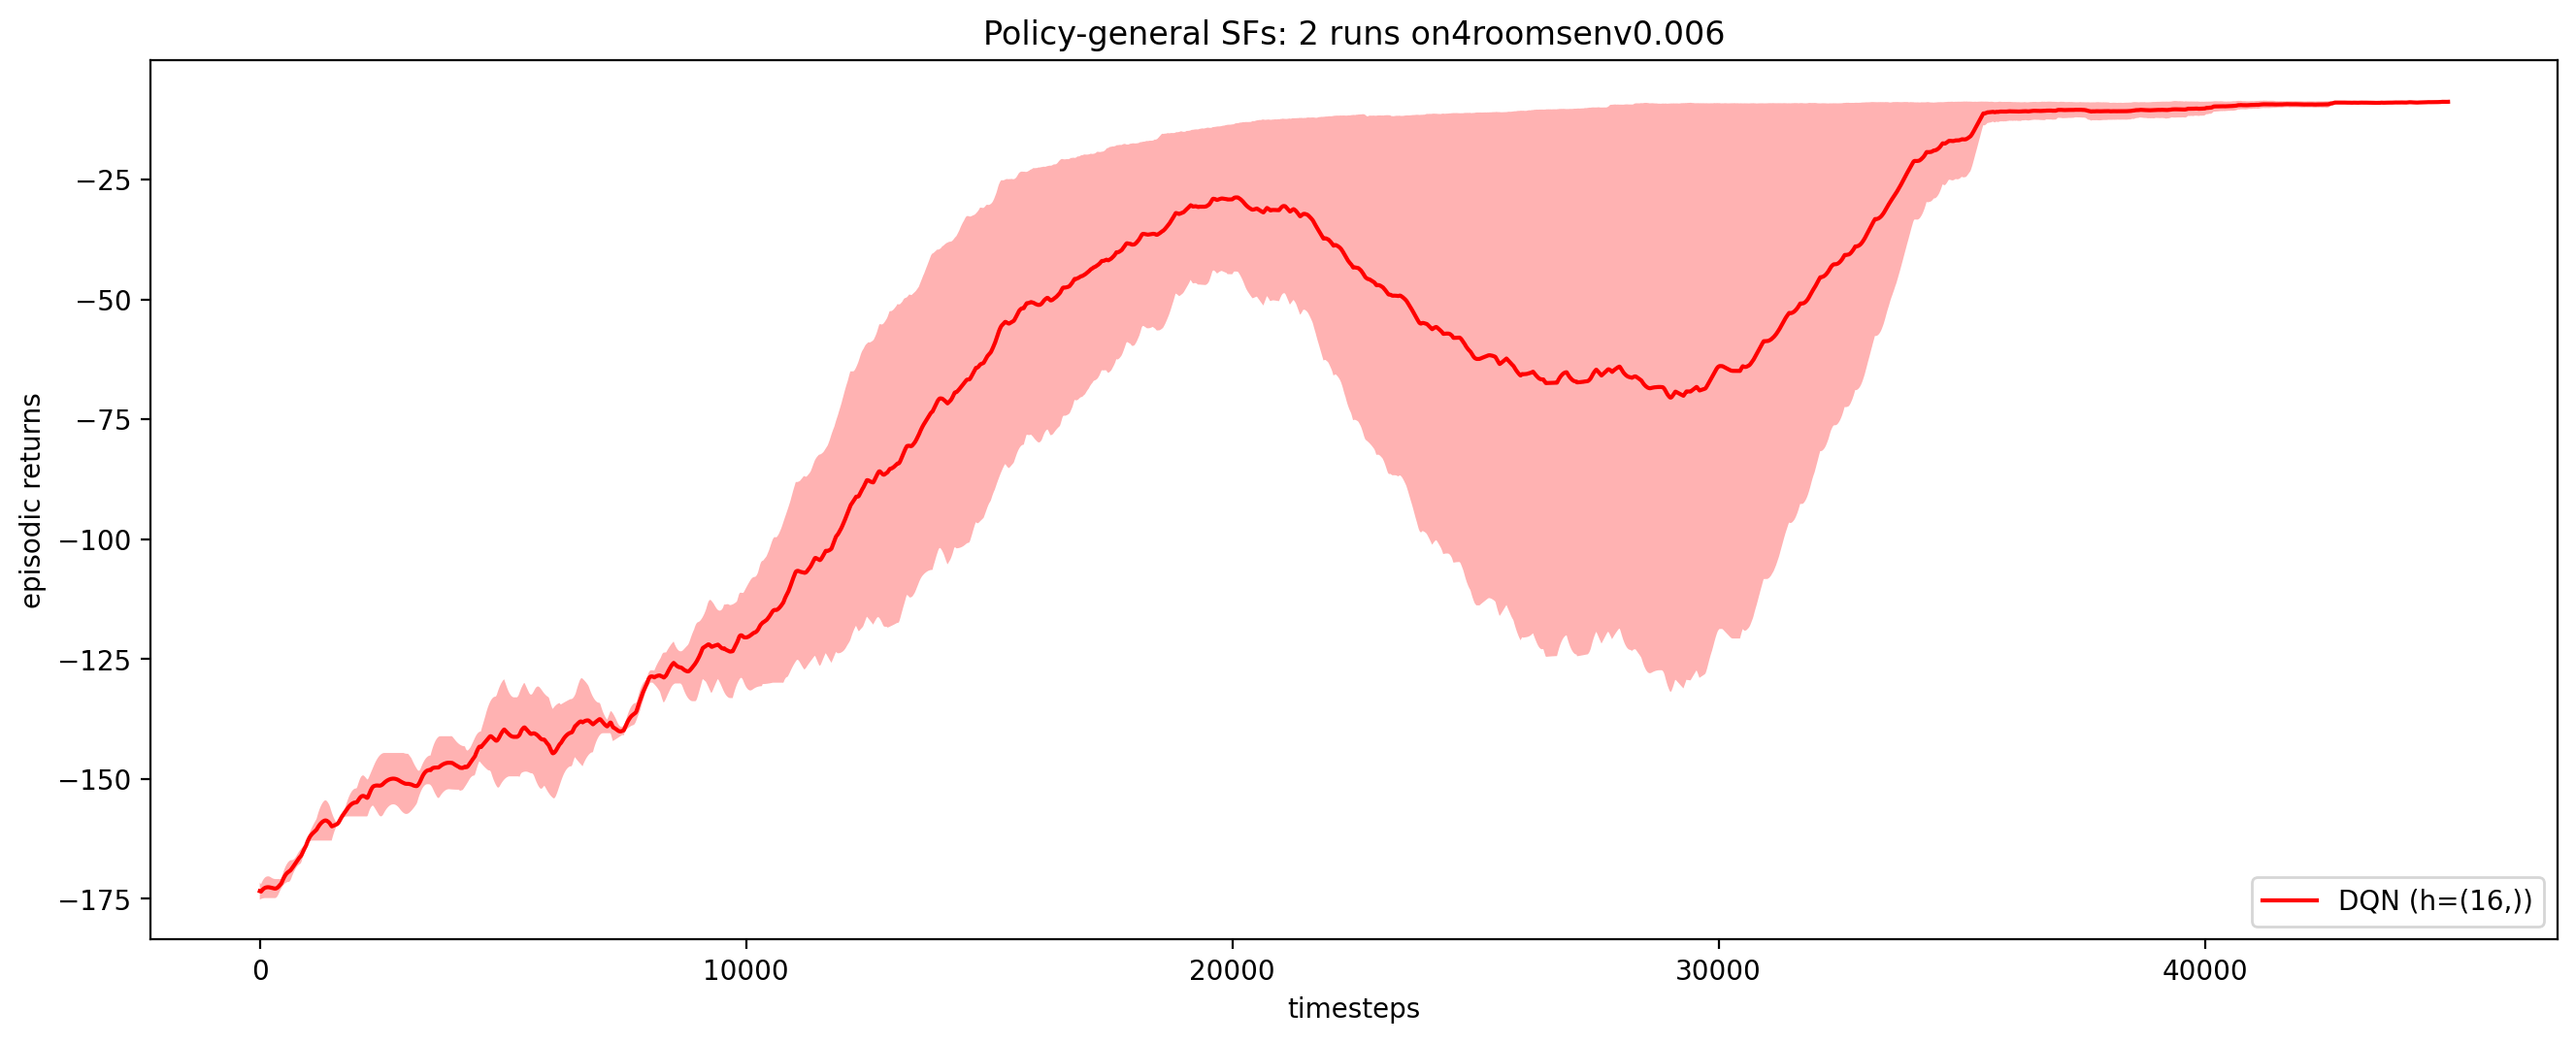

In [ ]:
learning_rate_dqn = 6e-3 #from 0.05 - 0.001
clip = 50000
smooth = clip // 10

def plot_rewards(rewards, plot_seperate=True , clip=clip, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dqn)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dqn)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dqn
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent


r_dqn_base_16 = runNAgents(dqn_feature, runs=2)

rewards_dict = {'DQN (h=(16,))': r_dqn_base_16[1:]}

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on' + layout + 'env' + str(learning_rate_dqn))

### Performance of AVDSR Agent with 2708 Parameters

runs:   0%|          | 0/2 [00:00<?, ?it/s]

_IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=['psi2q.w'])


2021-03-08 15:05:17,433 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2021-03-08 15:05:23,538 - root - INFO: steps 5000, episodic_return_test -160.90(24.73)
2021-03-08 15:05:29,386 - root - INFO: steps 10000, episodic_return_test -101.40(31.18)
2021-03-08 15:05:34,956 - root - INFO: steps 15000, episodic_return_test -5.70(1.10)
2021-03-08 15:05:40,893 - root - INFO: steps 20000, episodic_return_test -103.30(30.59)
2021-03-08 15:05:46,648 - root - INFO: steps 25000, episodic_return_test -4.80(1.12)
2021-03-08 15:05:52,312 - root - INFO: steps 30000, episodic_return_test -6.10(1.31)
2021-03-08 15:05:57,973 - root - INFO: steps 35000, episodic_return_test -5.90(1.08)
2021-03-08 15:06:03,840 - root - INFO: steps 40000, episodic_return_test -45.20(24.50)
2021-03-08 15:06:09,491 - root - INFO: steps 45000, episodic_return_test -6.80(0.90)
2021-03-08 15:06:15,172 - root - INFO: steps 50000, episodic_return_test -7.90(0.95)
runs:  50%|█████     | 1/2 [00:58<00:58, 58.48s/it]

_IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=['psi2q.w'])


2021-03-08 15:06:15,896 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2021-03-08 15:06:22,076 - root - INFO: steps 5000, episodic_return_test -141.00(28.50)
2021-03-08 15:06:28,100 - root - INFO: steps 10000, episodic_return_test -82.70(30.30)
2021-03-08 15:06:33,692 - root - INFO: steps 15000, episodic_return_test -6.30(1.20)
2021-03-08 15:06:39,418 - root - INFO: steps 20000, episodic_return_test -5.20(0.99)
2021-03-08 15:06:45,212 - root - INFO: steps 25000, episodic_return_test -25.30(18.43)
2021-03-08 15:06:50,938 - root - INFO: steps 30000, episodic_return_test -5.60(1.11)
2021-03-08 15:06:56,815 - root - INFO: steps 35000, episodic_return_test -7.70(1.11)
2021-03-08 15:07:02,692 - root - INFO: steps 40000, episodic_return_test -6.10(0.94)
2021-03-08 15:07:08,407 - root - INFO: steps 45000, episodic_return_test -6.80(0.83)
2021-03-08 15:07:14,192 - root - INFO: steps 50000, episodic_return_test -7.50(1.04)
runs: 100%|██████████| 2/2 [01:57<00:00, 58.75s/it]


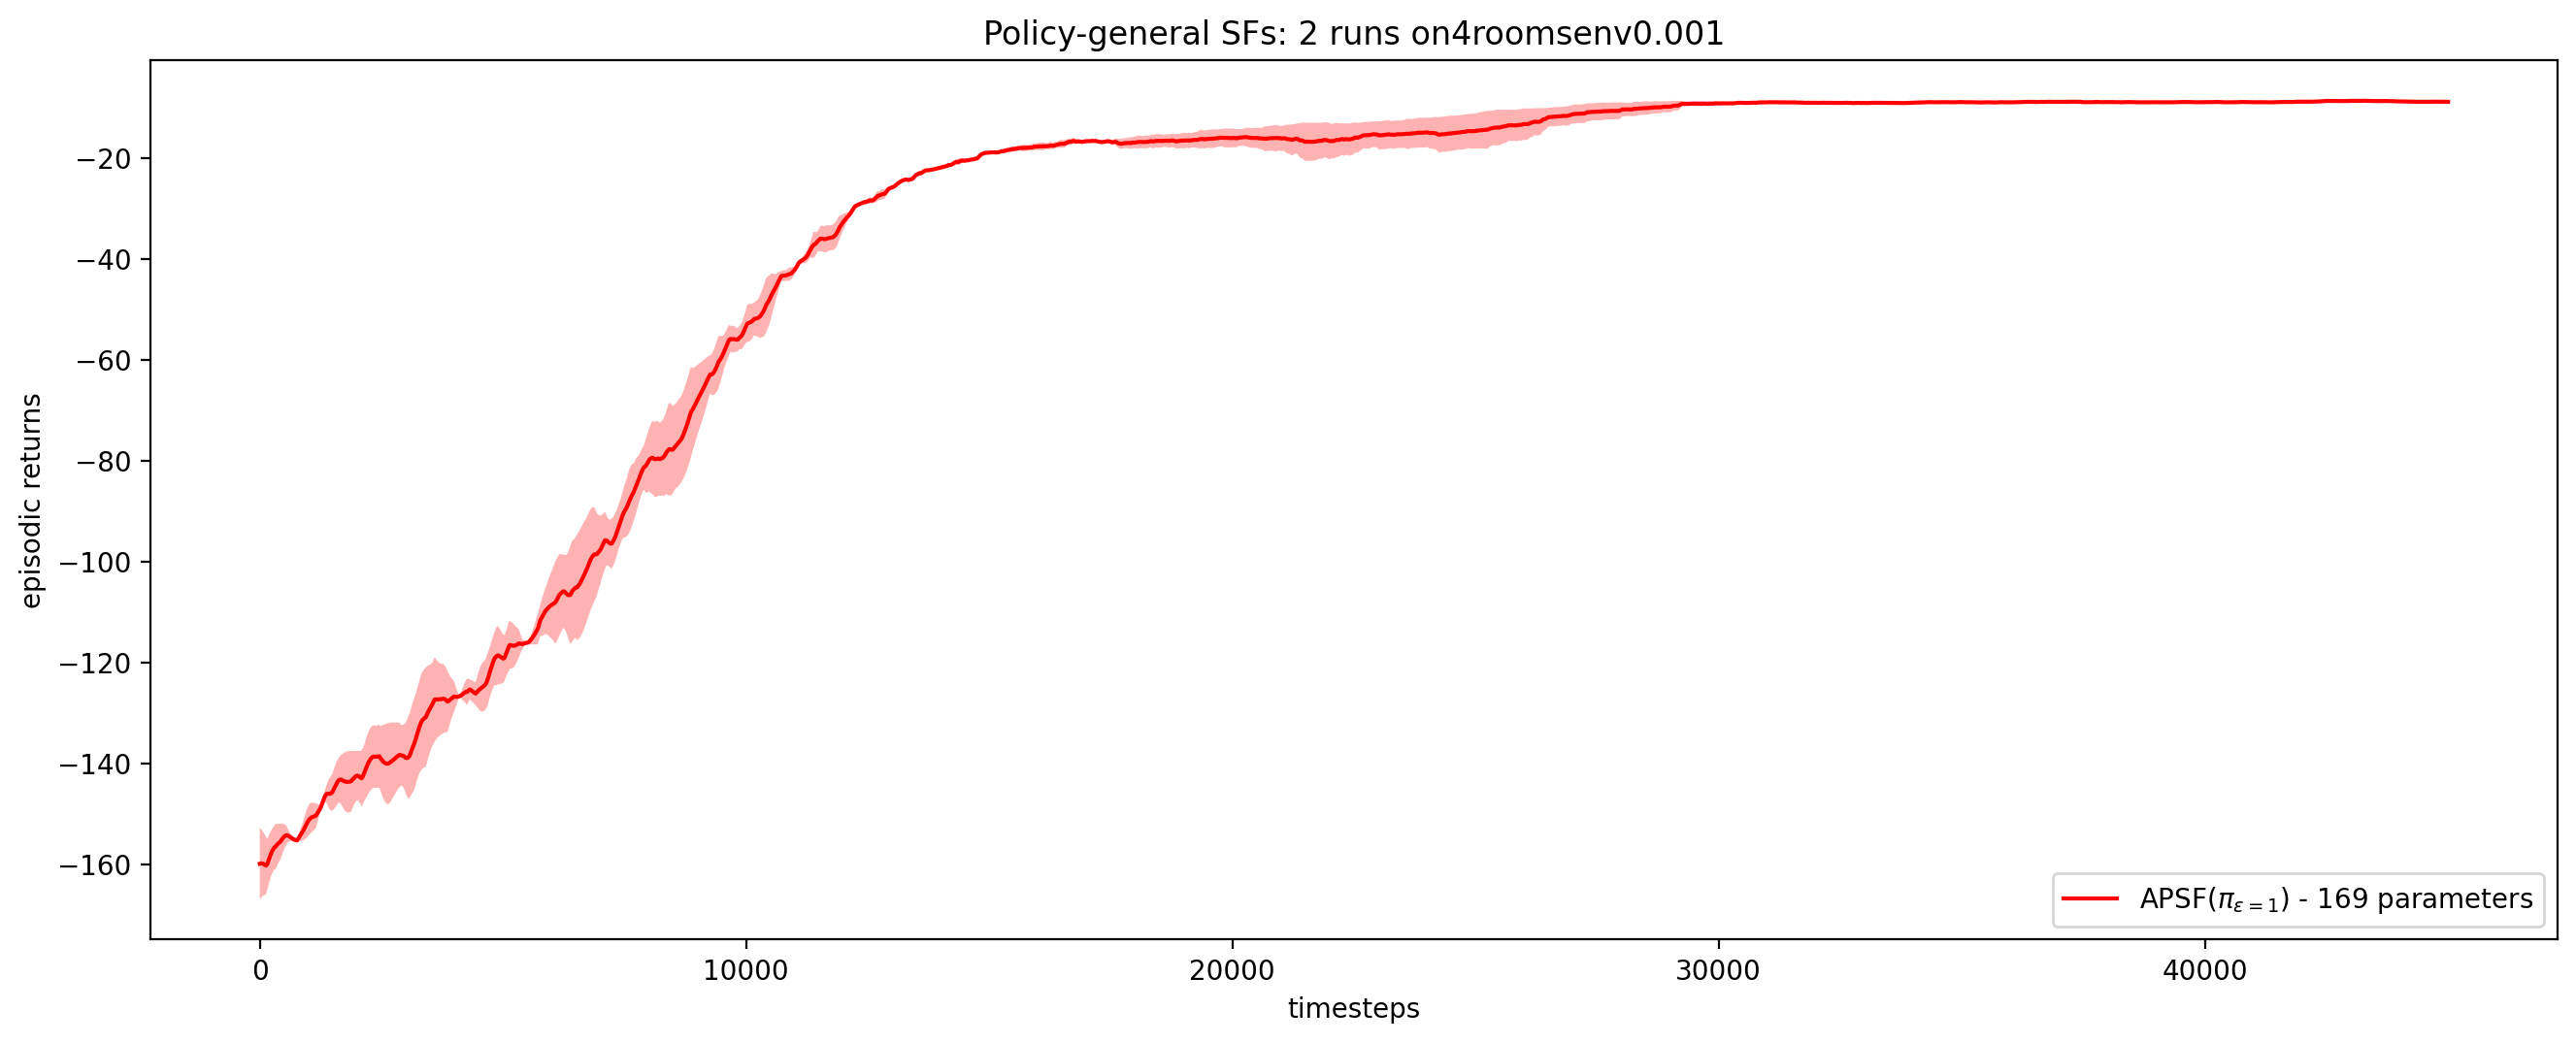

In [ ]:
learning_rate_dsr = 1e-3 #from 0.05 - 0.001
linear_schedule_dsr = 3e4
clip = 50000
smooth = clip // 10

max_step_dsr = 5e4

def plot_rewards(rewards, plot_seperate=True , clip=clip, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()


def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dsr)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dsr
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent


r_c1 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=1)

rewards_dict = {'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c1[1:]}

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on' + layout + 'env' + str(learning_rate_dsr))

### Performance of AVDSR Agent with 169 Parameters

runs:   0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>


2021-03-08 15:07:15,792 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2021-03-08 15:07:21,190 - root - INFO: steps 5000, episodic_return_test -62.60(28.45)
2021-03-08 15:07:26,514 - root - INFO: steps 10000, episodic_return_test -43.70(24.72)
2021-03-08 15:07:31,842 - root - INFO: steps 15000, episodic_return_test -7.30(1.00)
2021-03-08 15:07:37,106 - root - INFO: steps 20000, episodic_return_test -4.80(0.75)
2021-03-08 15:07:42,228 - root - INFO: steps 25000, episodic_return_test -7.90(0.83)
2021-03-08 15:07:47,422 - root - INFO: steps 30000, episodic_return_test -6.30(1.29)
2021-03-08 15:07:52,613 - root - INFO: steps 35000, episodic_return_test -5.80(1.19)
2021-03-08 15:07:57,860 - root - INFO: steps 40000, episodic_return_test -4.80(1.29)
2021-03-08 15:08:03,107 - root - INFO: steps 45000, episodic_return_test -7.70(1.11)
2021-03-08 15:08:08,293 - root - INFO: steps 50000, episodic_return_test -6.30(0.92)
runs:  50%|█████     | 1/2 [00:53<00:53, 53.14s/it]

<All keys matched successfully>


2021-03-08 15:08:08,916 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2021-03-08 15:08:14,125 - root - INFO: steps 5000, episodic_return_test -43.00(24.83)
2021-03-08 15:08:19,190 - root - INFO: steps 10000, episodic_return_test -6.20(0.68)
2021-03-08 15:08:24,272 - root - INFO: steps 15000, episodic_return_test -5.30(1.24)
2021-03-08 15:08:29,446 - root - INFO: steps 20000, episodic_return_test -6.00(1.17)
2021-03-08 15:08:34,558 - root - INFO: steps 25000, episodic_return_test -7.10(1.11)
2021-03-08 15:08:39,716 - root - INFO: steps 30000, episodic_return_test -5.60(1.15)
2021-03-08 15:08:44,776 - root - INFO: steps 35000, episodic_return_test -6.30(1.27)
2021-03-08 15:08:49,904 - root - INFO: steps 40000, episodic_return_test -4.80(1.23)
2021-03-08 15:08:54,989 - root - INFO: steps 45000, episodic_return_test -7.70(1.18)
2021-03-08 15:09:00,110 - root - INFO: steps 50000, episodic_return_test -6.30(0.72)
runs: 100%|██████████| 2/2 [01:44<00:00, 52.48s/it]


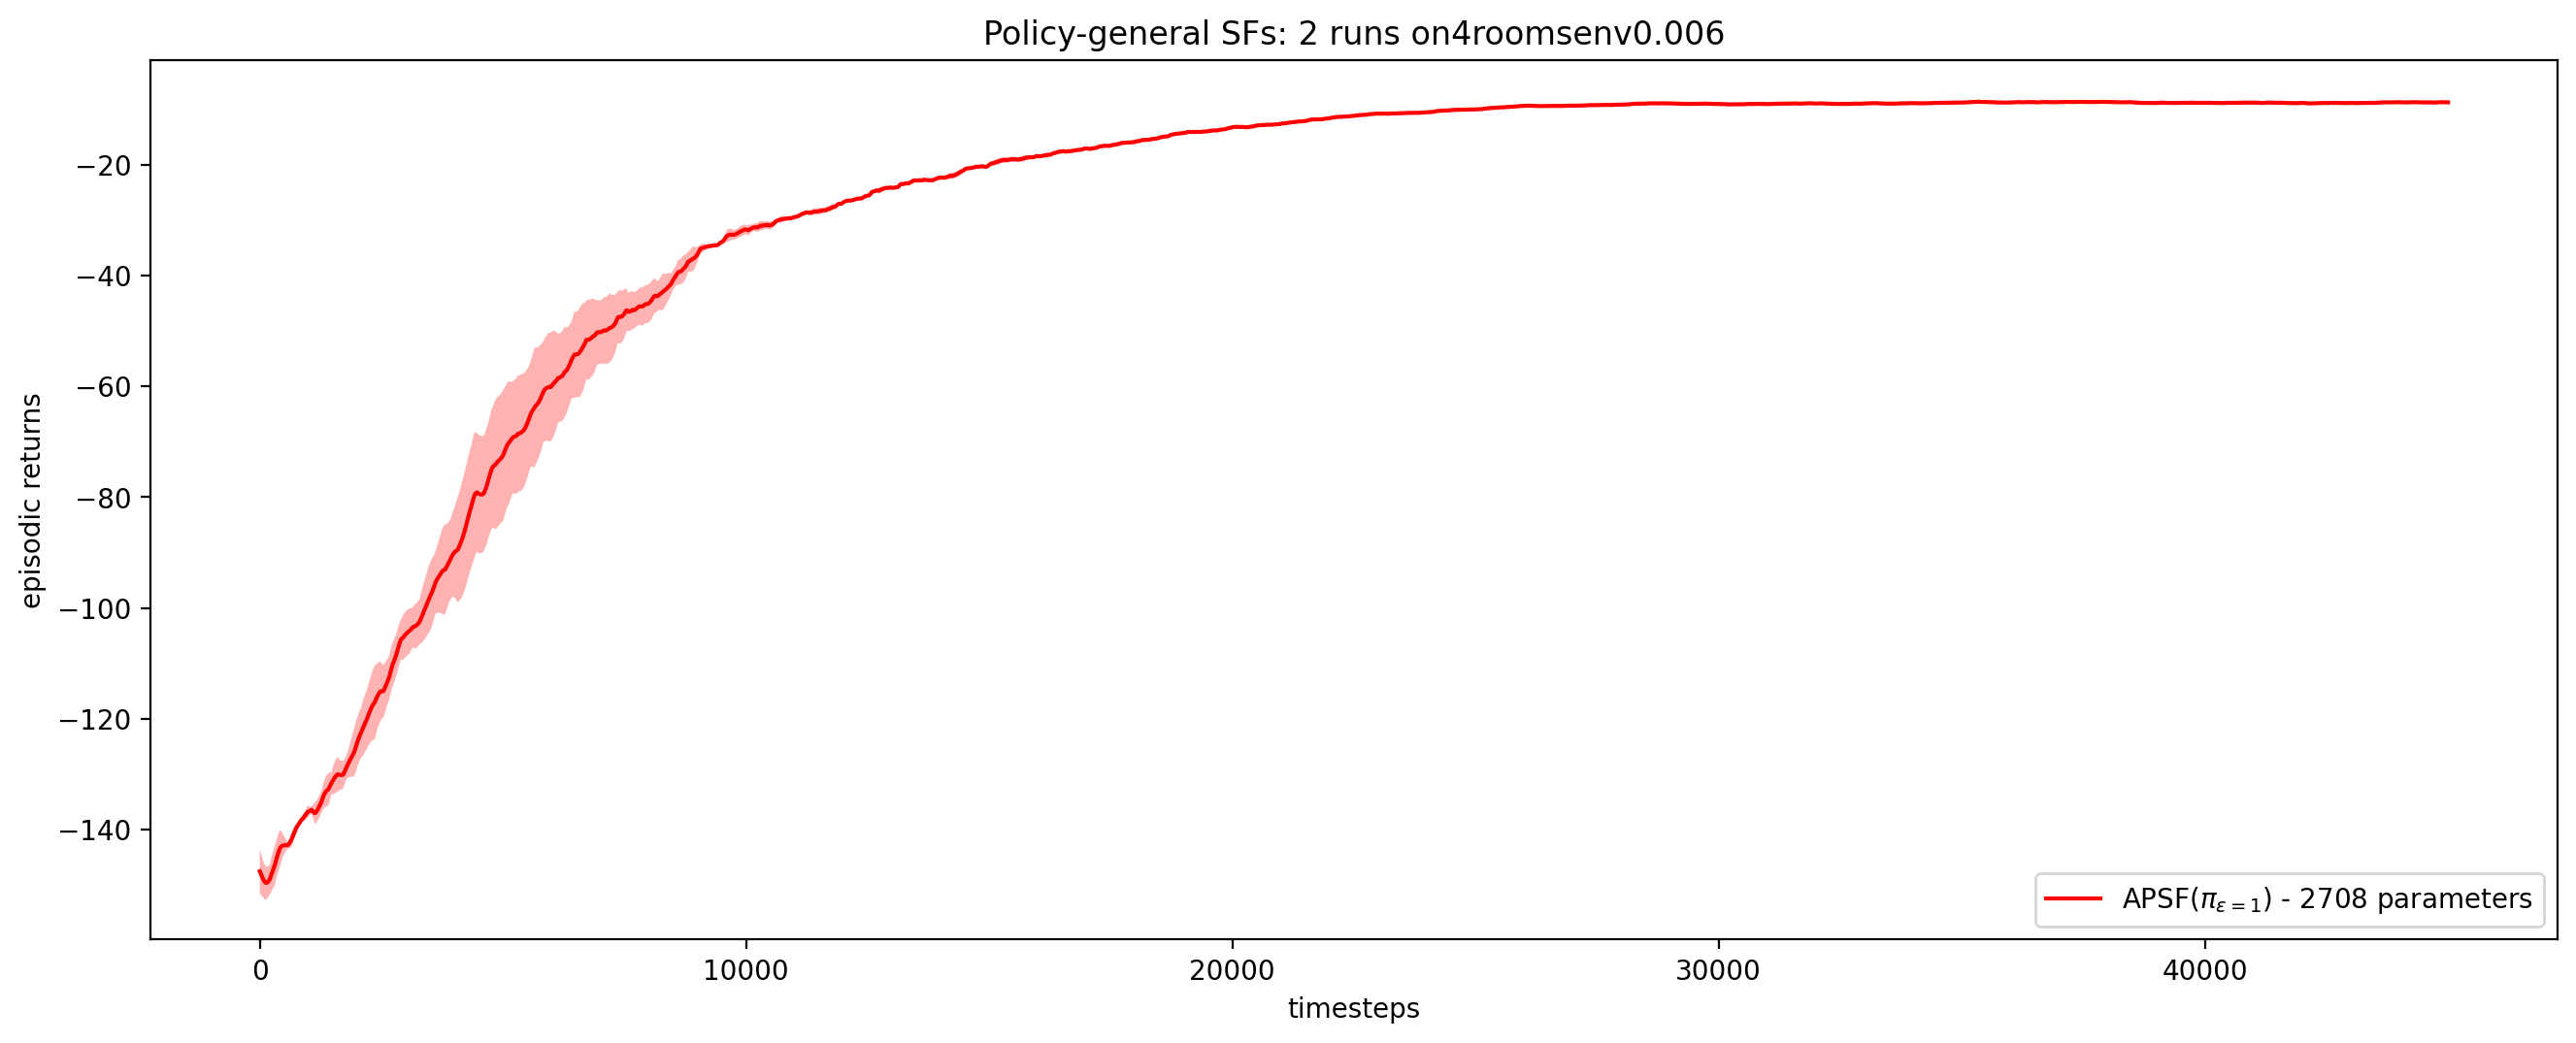

In [ ]:
learning_rate_dsr = 6e-3 #from 0.05 - 0.001
clip = 50000
smooth = clip // 10
max_step_dsr = 5e4
linear_schedule_dsr = 3e4

def plot_rewards(rewards, plot_seperate=True , clip=clip, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dsr)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dsr
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent


r_c2 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=0)

rewards_dict = {'APSF($\pi_{\epsilon=1}$) - 2708 parameters': r_c2[1:]}

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on' + layout + 'env' + str(learning_rate_dsr))

### Performance of GPI agent

In [ ]:
GPI.returns

[]

In [ ]:
gpi = runNAgents(gpi_feature, runs=2 , freeze=2, ref=None, style=0)

runs:   0%|          | 0/2 [00:00<?, ?it/s]2021-03-08 15:09:02,209 - root - INFO: steps 0, episodic_return_test -102.50(30.84)
2021-03-08 15:09:07,051 - root - INFO: steps 5000, episodic_return_test -141.60(28.21)
2021-03-08 15:09:11,912 - root - INFO: steps 10000, episodic_return_test -140.60(28.69)
2021-03-08 15:09:16,787 - root - INFO: steps 15000, episodic_return_test -141.90(28.08)
2021-03-08 15:09:21,175 - root - INFO: steps 20000, episodic_return_test -102.00(31.00)
2021-03-08 15:09:25,517 - root - INFO: steps 25000, episodic_return_test -104.70(30.14)
2021-03-08 15:09:29,399 - root - INFO: steps 30000, episodic_return_test -65.60(27.84)
2021-03-08 15:09:34,301 - root - INFO: steps 35000, episodic_return_test -142.80(27.63)
2021-03-08 15:09:38,901 - root - INFO: steps 40000, episodic_return_test -121.50(30.41)
2021-03-08 15:09:43,828 - root - INFO: steps 45000, episodic_return_test -142.40(27.82)
2021-03-08 15:09:48,560 - root - INFO: steps 50000, episodic_return_test -123.80(29

## Performance of Four Agents Using Corresponding Tuned Parameters



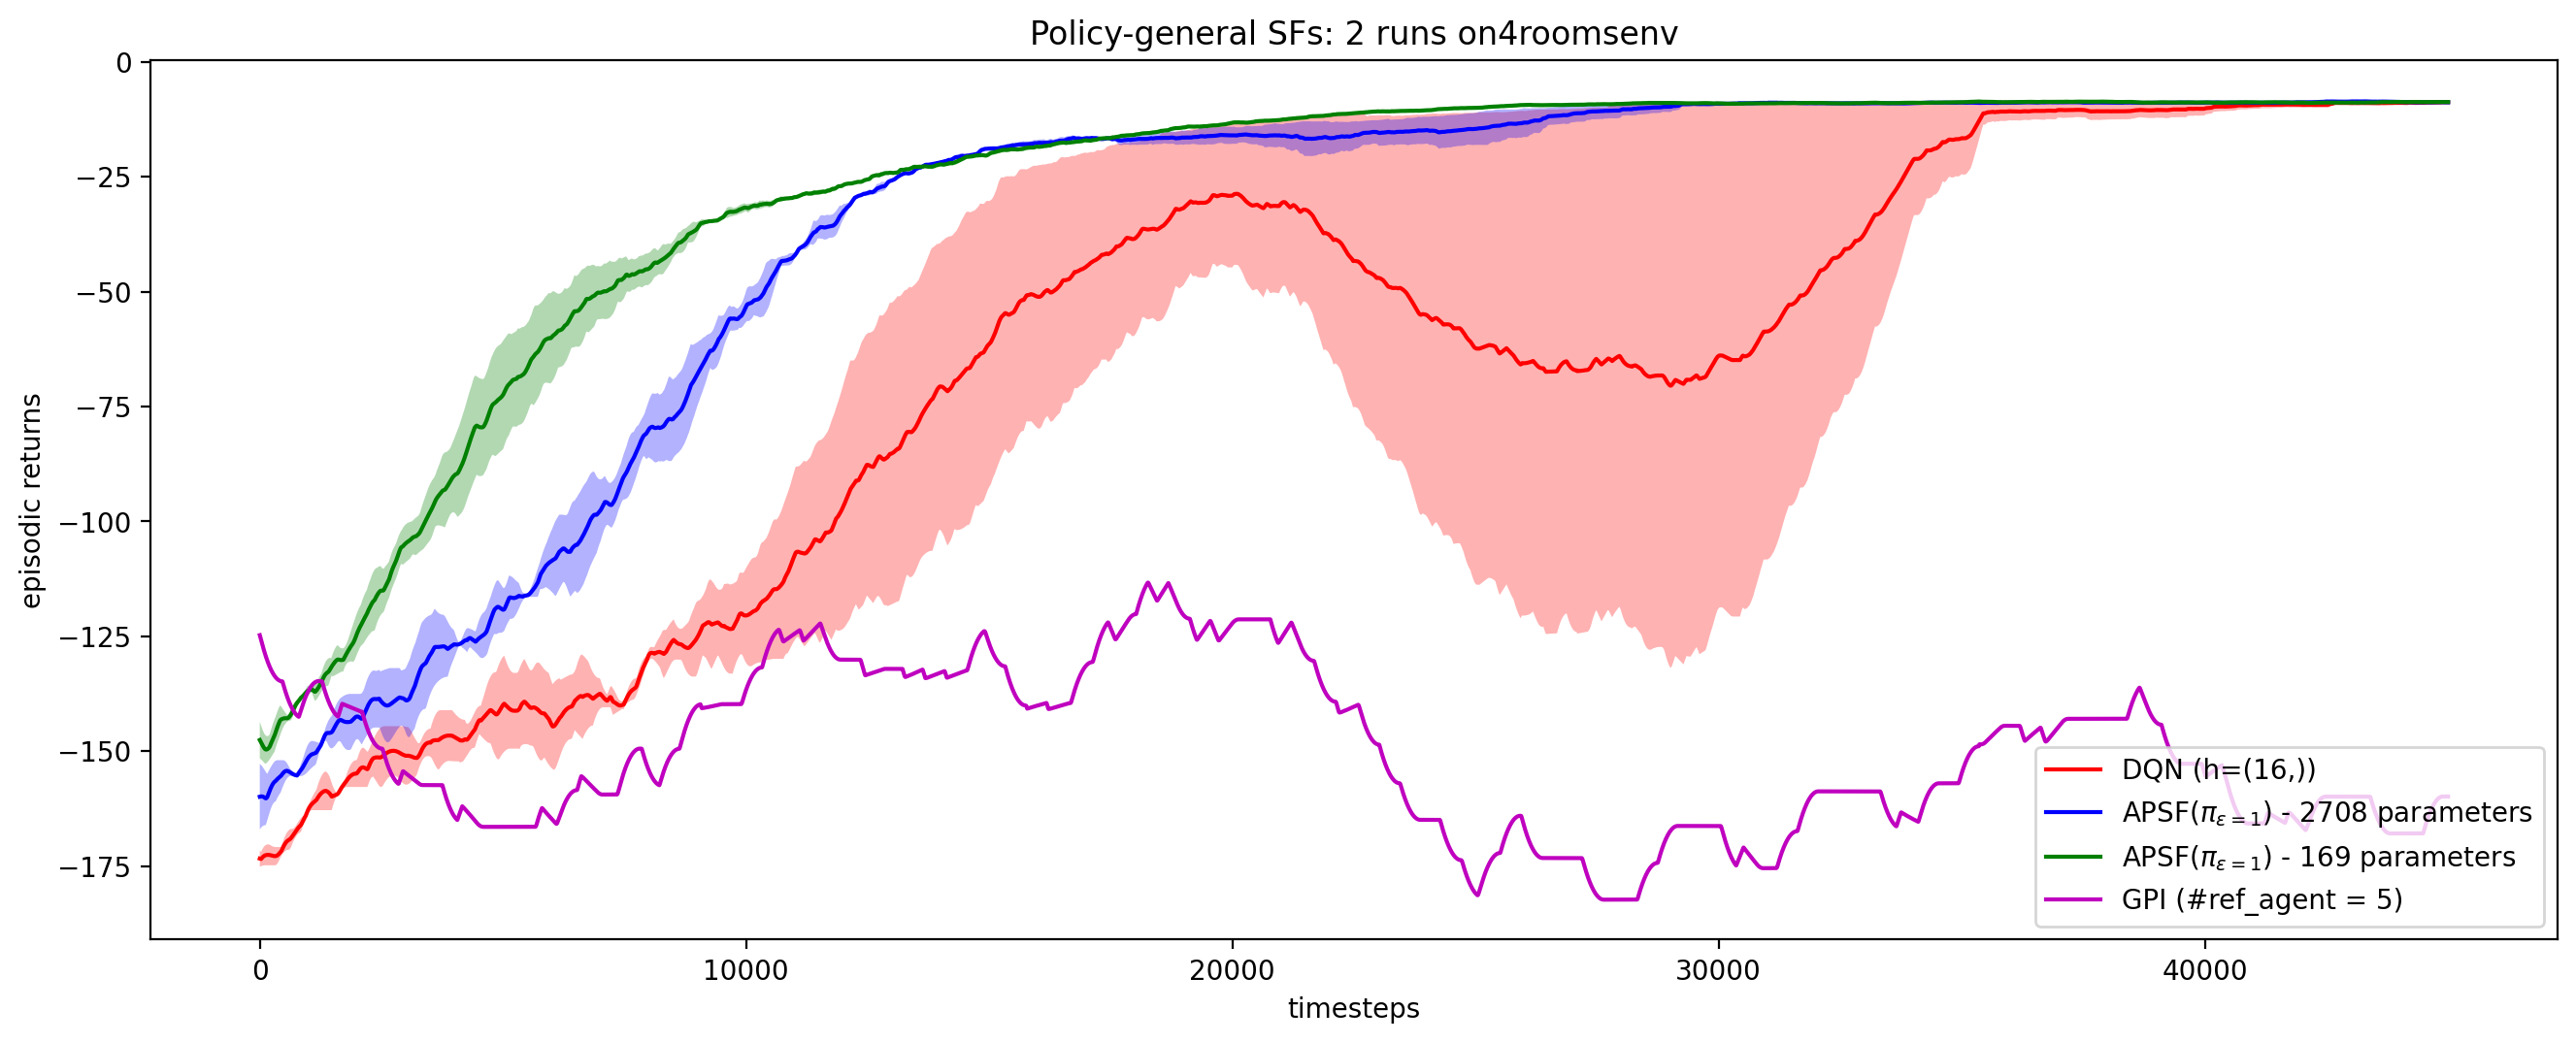

In [ ]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()


rewards_dict = {'DQN (h=(16,))': r_dqn_base_16[1:],
                'APSF($\pi_{\epsilon=1}$) - 2708 parameters': r_c1[1:],
                'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c2[1:],
                'GPI (#ref_agent = 5)' : gpi[1:]
               }

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on' + layout + 'env')